In [11]:
import os
import random
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
import pyvista as pv
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
data_dir = Path("/home/max/Desktop/python_projects/SimJeb")
root = data_dir / "SimJEB_surfmesh"
dest = data_dir / "SimJEB_sdf"
metadata_dir = data_dir / "SimJEB_metadata"

In [24]:
split = 0.85

In [3]:
paths = []
for path in root.glob("*.obj"):
    paths.append(path)

In [4]:
pv_points_downsample = pv.read(data_dir / "SimJEB_metadata" / "all_points_1M.vtk")

In [5]:
neighbours_distances = []
names_list = []
for path in tqdm(paths):
    mesh = pv.read(path)
    mesh = mesh.interpolate(pv_points_downsample)
    neighbours_distances.append(np.quantile(mesh["neighbours_distance"], q=0.95))
    names_list.append(path.stem)

100%|█████████████████████████████████████████| 381/381 [03:14<00:00,  1.96it/s]


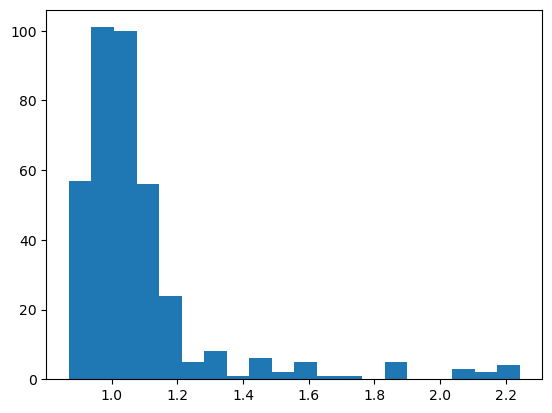

In [6]:
_ = plt.hist(neighbours_distances, bins=20)

In [7]:
mean, std = np.mean(neighbours_distances), np.std(neighbours_distances)

In [8]:
outiers_list = [
    n for d, n in zip(neighbours_distances, names_list) if np.abs(d - mean) > std
]

In [9]:
len(outiers_list)

34

In [10]:
mean, std

(1.0888479563007156, 0.23418807882920148)

In [12]:
with open(metadata_dir / "outliers.txt", "w") as f:
    f.writelines("\n".join(outiers_list))

In [13]:
outiers_set = set(outiers_list)

In [14]:
dataset = [n for n in names_list if n not in outiers_set]

In [16]:
random.shuffle(dataset)

In [25]:
split_int = int(len(dataset) * split)

In [26]:
train = dataset[:split_int]
test = dataset[split_int:]

In [27]:
with open(metadata_dir / "train.txt", "w") as f:
    f.writelines("\n".join(train))

In [28]:
with open(metadata_dir / "test.txt", "w") as f:
    f.writelines("\n".join(test))

In [29]:
len(train)

294

In [30]:
len(test)

53

In [4]:
with open(metadata_dir / "outliers.txt") as f:
    lines = f.readlines()

In [7]:
outliers = set([l.strip() for l in lines])

In [8]:
dataset = [p for p in paths if p.stem not in outliers]

In [9]:
len(dataset)

347

  0%|          | 0/381 [00:00<?, ?it/s]

/home/max/miniconda3/envs/dev/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


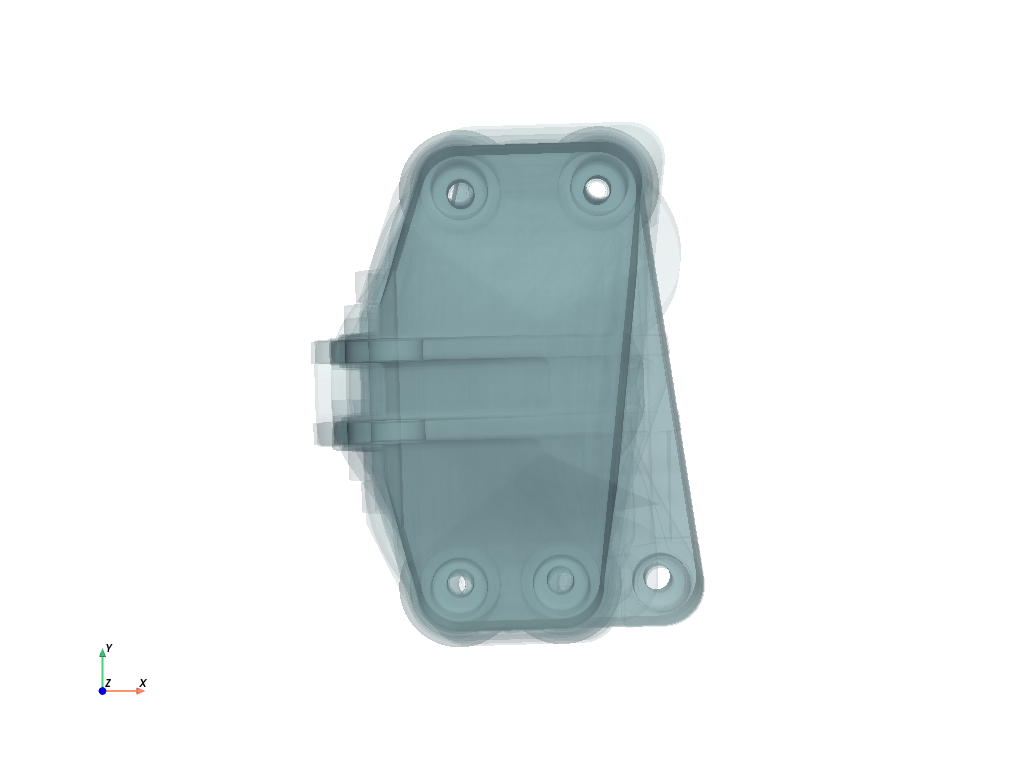

NameError: name 'Image' is not defined

In [10]:
for view in ["xy", "xz", "yz"]:
    
    pl = pv.Plotter()

    # Load each mesh, set transparency, and add it to the plotter
    for path in tqdm(paths):
        mesh = pv.read(path)

        # Add the mesh to the plotter
        pl.add_mesh(mesh, opacity=0.1)

    # Set the camera position to view
    pl.camera_position = view
    pl.add_axes()
    pl.show_axes_all()
    pl.show(auto_close=False)
    image = pl.screenshot(None, return_img=True)
    Image.fromarray(pl.screenshot(None, return_img=True)).save(metadata_dir/f"{view}_no_outliers.jpeg")